In [198]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import tqdm
import joblib

sys.path.append("../../../python")
from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
reload(parser)
reload(datatypes)

sys.path.append("..")
import cut_functions
reload(cut_functions)


# # importing required libraries 
# import ipympl
# # %matplotlib inline 
# %matplotlib widget 

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

In [199]:
data_dir="/home/tomren/geant_projects/musim_test/cedar"
data_dir="/home/tomren/geant_projects/musim_test/cedar_cosmic_n"
fname_comb = f"{data_dir}/series_2_digi_recon_skim.root"
# fname_comb = "/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/merged.root"
fname_comb = "/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/merged_p_1200runs.root"
fname_sig1 = "/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_25_digi_recon_skim.root"
fname_sig2 = "/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_45_digi_recon_skim.root"

fbkg = root.tfile_reader(fname_comb)
fbkg.ls()
## Get metadata
fbkg.get_tree("metadata_digi")
metadata_digi = fbkg.get_entry(0)
fbkg.get_tree("data;1")
print("Entries", fbkg.entries)

fsig1 = root.tfile_reader(fname_sig1)
fsig1.ls()
fsig1.get_tree("data;1")
print("Entries", fsig1.entries)

fsig2 = root.tfile_reader(fname_sig2)
fsig2.ls()
fsig2.get_tree("data;1")
print("Entries", fsig2.entries)

None
Entries 839934
None
Entries 9172
None
Entries 9120
TFile**		/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/merged_p_1200runs.root	
 TFile*		/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/merged_p_1200runs.root	
  KEY: TTree	metadata;1	Metadata for reconstruction
  KEY: TTree	metadata_digi;1	Metadata for digitization
  KEY: TTree	metadata_recon;1	Simulation metadata
  KEY: TParameter<int>	N_MERGED;1	
  KEY: TTree	data;1	Reconstruction Tree Skimmed
TFile**		/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_25_digi_recon_skim.root	
 TFile*		/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_25_digi_recon_skim.root	
  KEY: TTree	metadata;1	Metadata for reconstruction
  KEY: TTree	metadata_digi;1	Metadata for digitization
  KEY: TTree	metadata_recon;1	Simulation metadata
  KEY: TTree	data;1	Reconstruction Tree Skimmed
TFile**		/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_45_digi_recon_skim.root	
 TFile*		/home/tomren/geant_projects/musim_test

In [200]:
reload = True

if reload:
    k=1
    # res_bkg = cut_functions.run_processing(fbkg, entries=int(80000));
    # res_sig1 = cut_functions.run_processing(fsig1, entries=int(k*2000));
    # res_sig2 = cut_functions.run_processing(fsig2, entries=int(k*2000));
    res_bkg = cut_functions.run_processing(fbkg, entries=-1);
    res_sig1 = cut_functions.run_processing(fsig1, entries=-1);
    res_sig2 = cut_functions.run_processing(fsig2, entries=-1);    
    joblib.dump(res_bkg.data, "/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/rrq_bkg.joblib")
    joblib.dump(res_sig1.data, "/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/rrq_sig1.joblib")
    joblib.dump(res_sig2.data, "/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/rrq_sig2.joblib")

else:
    res_bkg_data = joblib.load("/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/rrq_bkg.joblib")
    res_sig1_data = joblib.load("/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/rrq_sig1.joblib")
    res_sig2_data = joblib.load("/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/rrq_sig2.joblib")    
    res_bkg = cut_functions.RQ_dict(res_bkg_data)
    res_sig1 = cut_functions.RQ_dict(res_sig1_data)
    res_sig2 = cut_functions.RQ_dict(res_sig2_data)

Entries 839934
Finished
Entries 9172
Finished
Entries 9120
Finished


In [201]:
colors = ["C0", "C2", "C1"]
labels = ["Bkg p", "HXX 25 GeV", "HXX 45 GeV"]

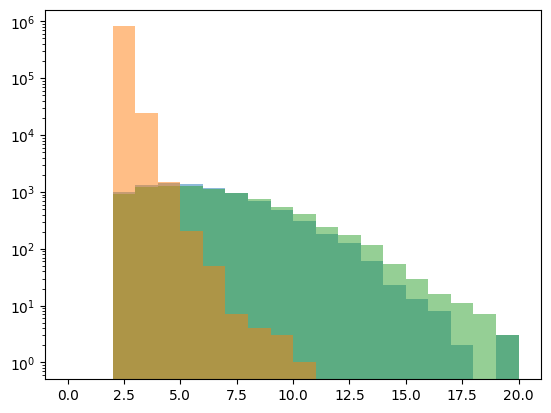

In [202]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    # plt.hist(res["vertex_ntracks"] - res["vertex_ndownward_track"], bins=20,range=(0,20), alpha=0.5);
    res.add_cut(lambda res: res["vertex_ntracks"]>2, "N_tracks")
    res.add_cut(lambda res: np.ones_like(res["vertex_ntracks"], dtype=bool), "True")
    plt.hist(res["vertex_ntracks"], bins=20,range=(0,20), alpha=0.5, color=colors[i])
plt.yscale("log")
plt.show()

8179
8189
26429


(0.0, 30.0)

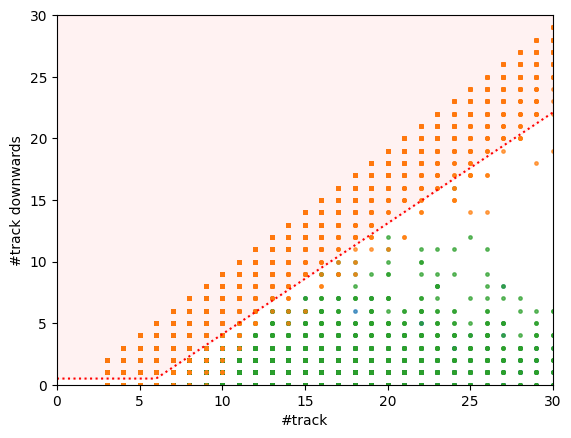

In [203]:
f_ndown_cut = lambda x: ((x-6)*.9 + 0.5) * (x >=6) + 0.5 * (x<6)
c_ndown = lambda data: res["event_ndownward_track"] < f_ndown_cut(res["event_ntracks"])

for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    res.add_cut(c_ndown, "N track downward")

    # mask = res.get_cut("N_hits vs N_veto") & res.get_cut("N_hits vs N_veto 2") # & res.get_cut("N_tracks") #| res.get_cut("True")
    mask = res.get_cut("N_tracks")#res.get_cut("True")
    print(sum(mask))
    
    x = (res["event_ntracks"])[mask]
    y = res["event_ndownward_track"][mask]
    plt.scatter(x, y, alpha=0.7, s=6, color=colors[i])


xlim=30
ylim=30
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_ndown_cut(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_ndown_cut(x_plot), ylim, color="r", alpha=0.05)
plt.xlabel("#track")
plt.ylabel("#track downwards")
plt.xlim(0,xlim)
plt.ylim(0,ylim)


7869
7772
4145


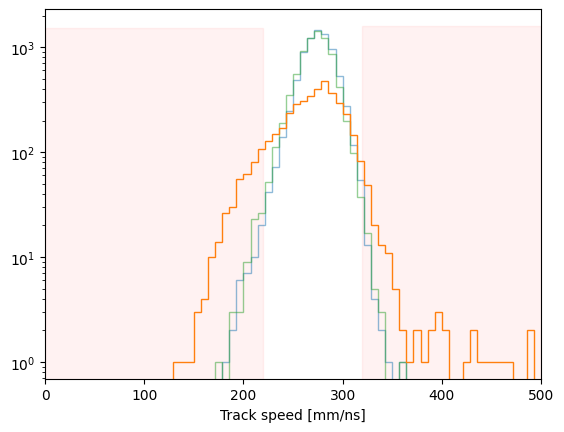

In [244]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask = res.get_cut("N_tracks") & res.get_cut("N track downward")
    print(sum(mask))
    plt.hist(res["vertex_slowest_track"][mask], bins=70,range=(0,500), alpha=0.5+ np.heaviside(i-1, 0) * 0.5, color=colors[i], histtype="step");

    res.add_cut(lambda res: (res["vertex_slowest_track"]> 220) & (res["vertex_slowest_track"]<320), "track speed")
    
plt.xlabel("Track speed [mm/ns]")
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 0, 220, color="r", alpha=0.05)
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 320, 500, color="r", alpha=0.05)

plt.xlim(0,500)
plt.yscale("log")
plt.show()

(0.0, 400.0)

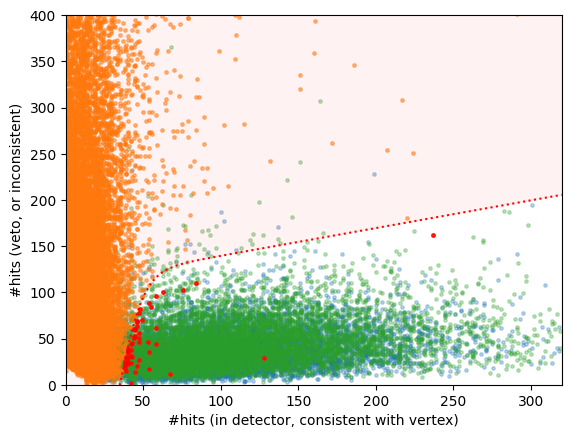

In [306]:
def f_nhits_cut(x):
    x0 = 35
    squeeze = 15
    yscale = 120
    slope = 0.3
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    return y
    # ((x-6)*.9 + 0.5) * (x >=6) + 0.5 * (x<6)
    # return (x-30)*4 * (x <= 70) + 160*(x>70)
c_nhits = lambda data: (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut(res["vertex_ndigi_active_after_comp"])

for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
      
    mask = res.get_cut("track speed") & res.get_cut("N_tracks") # & res.get_cut("N track downward")#| res.get_cut("True")
    x = (res["vertex_ndigi_active_after_comp"])[mask]
    y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[mask]
    plt.scatter(x, y,  alpha=0.3+ np.heaviside(i-1, 0) * 0.2, s=6, color=colors[i])

    res.add_cut(c_nhits, "N_hits vs N_veto")

# confirm cut
res = res_bkg
mask = res.get_cut("N_hits vs N_veto") & res.get_cut("track speed") & res.get_cut("N_tracks") 
x = (res["vertex_ndigi_active_after_comp"])[mask]
y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[mask]
plt.scatter(x, y,  alpha=0.8, s=6, color="r")


xlim = 320
ylim = 400
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut(x_plot), ylim, color="r", alpha=0.05)
plt.xlabel("#hits (in detector, consistent with vertex)")
plt.ylabel("#hits (veto, or inconsistent)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

7712
7589
53


(0.0, 250.0)

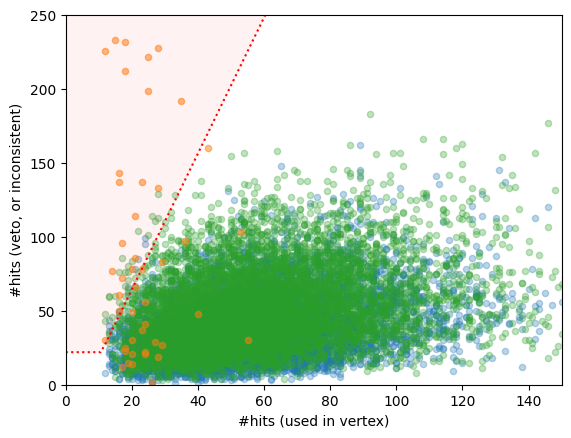

In [307]:
def f_nhits_cut2(x):
    line = (x-6)*4.6
    ycut = 22
    return line * (line>ycut) +  ycut * (line<=ycut)
c_nhits2 = lambda data: (res["event_nhits"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut2(res["event_track_nhits"])

for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask = res.get_cut("N_hits vs N_veto") & res.get_cut("track speed") &res.get_cut("N_tracks") #| res.get_cut("True")
    print(sum(mask))
    # mask = res.get_cut("True")
    # mask = res.get_cut("N_tracks") 

    x = (res["event_track_nhits"])[mask]
    y = (res["event_nhits"] - res["vertex_ndigi_active_after_comp"])[mask]
    plt.scatter(x, y, alpha=0.3+ np.heaviside(i-1, 0) * 0.2, s=20, color=colors[i])

    # Add new cut
    res.add_cut(c_nhits2, "N_hits vs N_veto 2")


xlim=150
ylim=250
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut2(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut2(x_plot), ylim, color="r", alpha=0.05)

plt.xlabel("#hits (used in vertex)")
plt.ylabel("#hits (veto, or inconsistent)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

7792
7678
3640


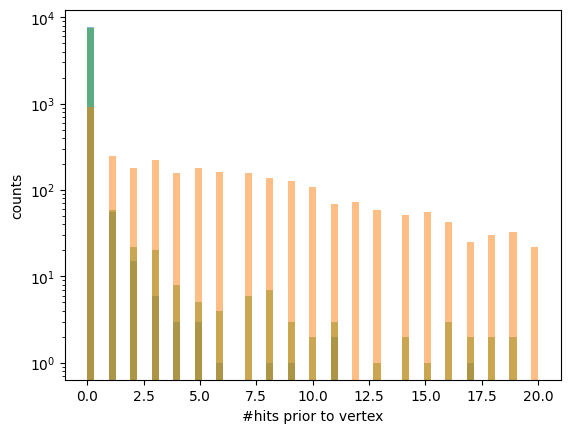

In [319]:
c_track_before = lambda data: res["vertex_ndigi_before_limited"] <= 0

for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    res.add_cut(c_track_before, "N digi before")
    mask =   res.get_cut("N track downward") & res.get_cut("track speed") &res.get_cut("N_tracks") # res.get_cut("N_hits vs N_veto") &res.get_cut("N_hits vs N_veto 2") #| res.get_cut("True")
    # mask =  res.get_cut("True")
    print(sum(mask))    
    plt.hist(res["vertex_ndigi_before_limited"][mask], range=(0,20), bins=21*3, alpha=0.5, color=colors[i])
plt.xlabel("#hits prior to vertex")
plt.ylabel("counts")
plt.yscale("log")

7870
7428
7528
6692
15
2


(-1.0, 1.0)

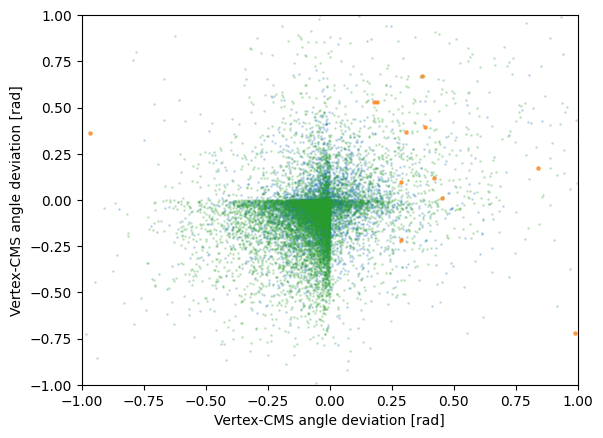

In [320]:
# c_angle_hv = lambda data: ((abs(res["vertex_cms_angle_h"])<0.5) & (abs(res["vertex_cms_angle_v"]) < 0.5))
# c_angle_hv = lambda data: (((res["vertex_cms_angle_h"])<0.2) & ((res["vertex_cms_angle_v"]) < 0.2))
c_angle_hv = lambda data: (res["vertex_cms_angle_h"] + res["vertex_cms_angle_v"] < 0.2)

for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    res.add_cut(c_angle_hv, "Angle to CMS")
    mask = res.get_cut("N track downward") & res.get_cut("track speed") & res.get_cut("N digi before") & res.get_cut("N_hits vs N_veto") & res.get_cut("N_hits vs N_veto 2") # &res.get_cut("N_tracks")  | res.get_cut("True")
    # mask = res.get_cut("N_tracks")
    # mask = res.get_cut("True")
    print(sum(mask))
    
    x = (res["vertex_cms_angle_h"])[mask]
    y = res["vertex_cms_angle_v"][mask]
    # y = (res["vertex_cms_angle_h_span"] + res["vertex_cms_angle_h"])[mask]
    # y = (res["vertex_cms_angle_h_span"] + res["vertex_cms_angle_h"] - res["vertex_cms_angle_h_mean"])[mask]
    # plt.scatter(x, y, alpha=0.3 + np.heaviside(i-1, 0) * (-0.1), s=5 + np.heaviside(i-1, 0) * (-4.5), color=colors[i])
    plt.scatter(x, y, alpha=0.2 + np.heaviside(i-1, 0) * (0.5), s=1 + np.heaviside(i-1, 0) * (4), color=colors[i])

    print(sum((x+y)<0.2))

# plt.gca().add_patch(mpl.patches.Rectangle([-0.5,-0.5],1,1,facecolor="none", ec="r"))

plt.xlabel("Vertex-CMS angle deviation [rad]")
plt.ylabel("Vertex-CMS angle deviation [rad]")
# plt.yscale("log")
plt.xlim(-1,1)
plt.ylim(-1,1)

In [321]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask =  res.get_cut("N track downward") & \
            res.get_cut("N digi before") & \
            res.get_cut("track speed") & \
            res.get_cut("Angle to CMS")

    # mask =  res.get_cut("N_hits vs N_veto") & \
    #         res.get_cut("N_hits vs N_veto 2")

            # res.get_cut("Angle to CMS") #| res.get_cut("True")
    print(sum(mask))

7784
7062
12694


7870
7528
15


Text(0, 0.5, 'Vertex-CMS deviation [rad]')

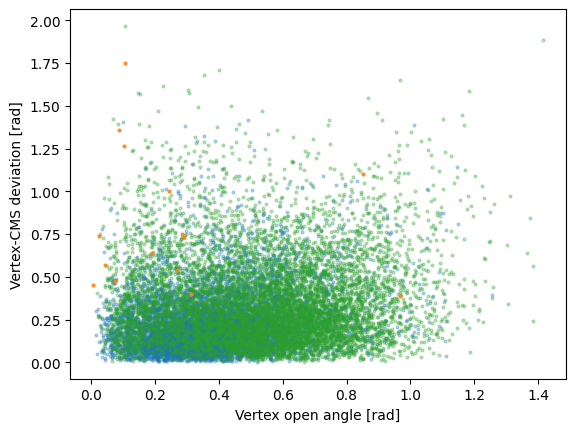

In [322]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask =  res.get_cut("N track downward") & \
            res.get_cut("N digi before") & \
            res.get_cut("track speed") & \
            res.get_cut("N_hits vs N_veto") & \
            res.get_cut("N_hits vs N_veto 2") #& \

            # res.get_cut("Angle to CMS") #| res.get_cut("True")
    print(sum(mask))

    # mask = res.get_cut("N track downward") & res.get_cut("N_hits vs N_veto")
    # mask = res.get_cut("N track downward") & res.get_cut("N_hits vs N_veto") & res.get_cut("N track upward") & res.get_cut("N digi before") #| res.get_cut("True")

    x = res["vertex_open_angle"][mask]
    y = res["vertex_cms_angle"][mask] # vertex_cms_angle_h vertex_cms_angle
    # plt.scatter(x, y, alpha=0.3 + np.heaviside(i-1, 0) * (-0.2), s=1, color=colors[i])
    plt.scatter(x, y, alpha=0.3 + np.heaviside(i-1, 0) * (0.5), s=4, color=colors[i])

plt.xlabel("Vertex open angle [rad]")
plt.ylabel("Vertex-CMS deviation [rad]")
# plt.yscale("log")

7428
6692
2


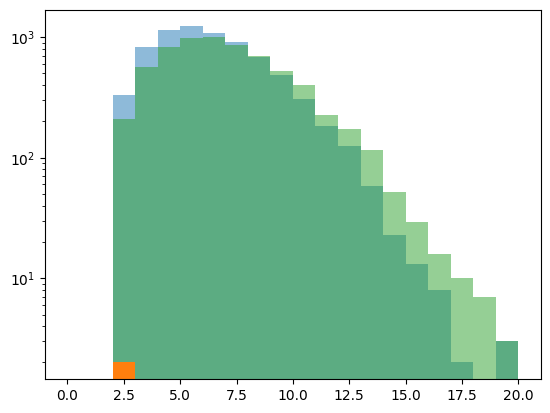

In [323]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask =  res.get_cut("N_hits vs N_veto") & \
            res.get_cut("N_hits vs N_veto 2") & \
            res.get_cut("N track downward") & \
            res.get_cut("N digi before") & \
            res.get_cut("track speed") & \
            res.get_cut("Angle to CMS") #| res.get_cut("True")
    
    print(sum(mask))
    # plt.hist((res["vertex_ntracks"] - res["vertex_ndownward_track"])[mask], bins=20,range=(0,20), alpha=0.5);
    plt.hist(res["vertex_ntracks"][mask], bins=20,range=(0,20), alpha=0.5+ np.heaviside(i-1, 0) * 0.5, color=colors[i]);
plt.yscale("log")
plt.show()

8179
8189
26429


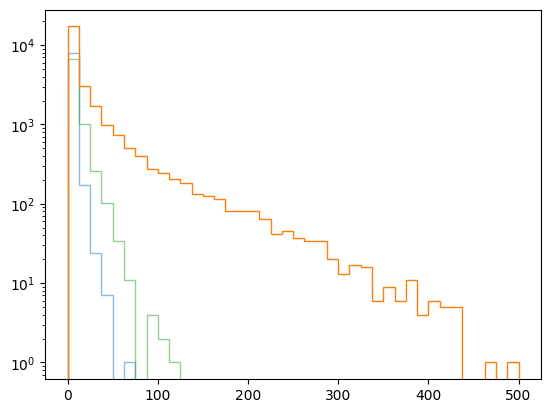

In [214]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask = res.get_cut("N_tracks")
    print(sum(mask))
    # plt.hist((res["vertex_ntracks"] - res["vertex_ndownward_track"])[mask], bins=20,range=(0,20), alpha=0.5);
    plt.hist(res["vertex_ndigi_veto_after_comp"][mask], bins=40,range=(0,500), alpha=0.5+ np.heaviside(i-1, 0) * 0.5, color=colors[i], histtype="step");
plt.yscale("log")
plt.show()

(-1.0, 50.0)

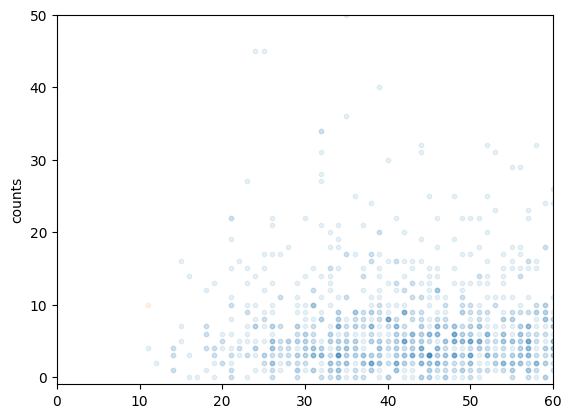

In [164]:
for res in [res_sig1, res_bkg]:
    mask =  res.get_cut("N_hits vs N_veto") & \
            res.get_cut("N_hits vs N_veto 2") & \
            res.get_cut("N track downward") & \
            res.get_cut("N digi before") & \
            res.get_cut("Angle to CMS") #| res.get_cut("True")

    # mask = res.get_cut("N digi before")
    # plt.hist(res["vertex_ndigi_veto_after_comp"][mask], bins=51, alpha=0.5, range=(-1,20))
    plt.scatter(res["event_track_nhits"][mask],res["vertex_ndigi_veto_after"][mask], s=10, alpha=0.1)
    # plt.scatter(res["vertex_ndigi_active_after_comp"][mask],res["vertex_ndigi_veto_after"][mask], s=10, alpha=0.5)

plt.ylabel("counts")
# plt.yscale("log")
plt.xlim(0,60)
plt.ylim(-1,50)

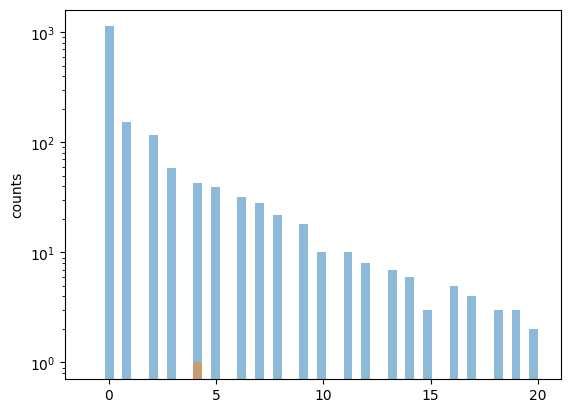

In [83]:
for res in [res_sig1, res_bkg]:
    mask =  res.get_cut("N_hits vs N_veto") & \
            res.get_cut("N_hits vs N_veto 2") & \
            res.get_cut("N track downward") & \
            res.get_cut("N digi before") & \
            res.get_cut("Angle to CMS") #| res.get_cut("True")
    plt.hist(res["vertex_ndigi_veto_after_comp"][mask], bins=51, alpha=0.5, range=(-1,20))

plt.ylabel("counts")
plt.yscale("log")

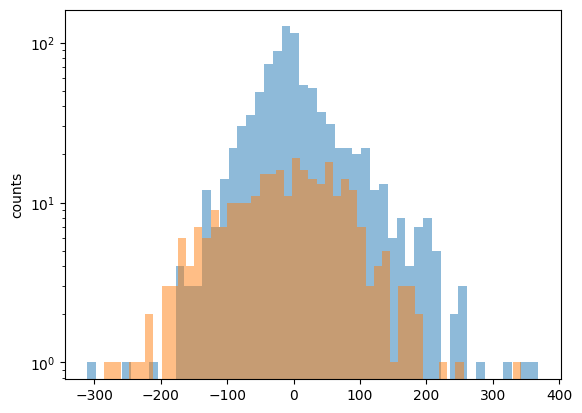

In [156]:
for res in [res_sig2, res_bkg]:
    mask_basic = res["vertex_ntracks"]>2
    # plt.hist(res["vertex_hits_trend_3"], bins=51, alpha=0.5)
    plt.hist(res["vertex_hits_trend_2b"].astype(int)[mask_basic], bins=51, alpha=0.5)
    # plt.hist(res["vertex_hits_trend_2"][mask_basic & (res["vertex_topfrac"]>0.5)], bins=51, alpha=0.5)
    # plt.hist(res["vertex_hits_trend_2"][mask_basic & (res["vertex_topfrac"]<0.5)], bins=51, alpha=0.5)
plt.ylabel("counts")
plt.yscale("log")

In [1112]:
dirs = []
for i in event.vertices[0].track_ids:
    t = event.tracks[i]
    print(t.vdirection)
    dirs.append(t.vdirection)



rrq.min_enclosing_cone(dirs), min_enclosing_cone_optimized(dirs[:2])

[0.237 0.791 0.565]
[0.048 0.744 0.666]
[ 0.588 -0.171  0.79 ]


((array([-0.162,  0.94 , -0.3  ]), 2.0870160109656717, 1.3831907047740408),
 (array([0.143, 0.772, 0.619]), 0.10967801194960808))

In [1086]:
rrq = cut_functions.RRQ(event)
open_angle_max, open_angle_mean, axis, angle_diffh, angle_diffv, angle_diff_abs = rrq.eval_cone()
open_angle_mean, axis

(1.3831907047740408, array([-0.162,  0.94 , -0.3  ]))

In [1114]:
%timeit -r 100 -n 10 min_enclosing_cone_optimized(dirs[:2])

1.37 ms ± 65.7 μs per loop (mean ± std. dev. of 100 runs, 10 loops each)


15
7 475944


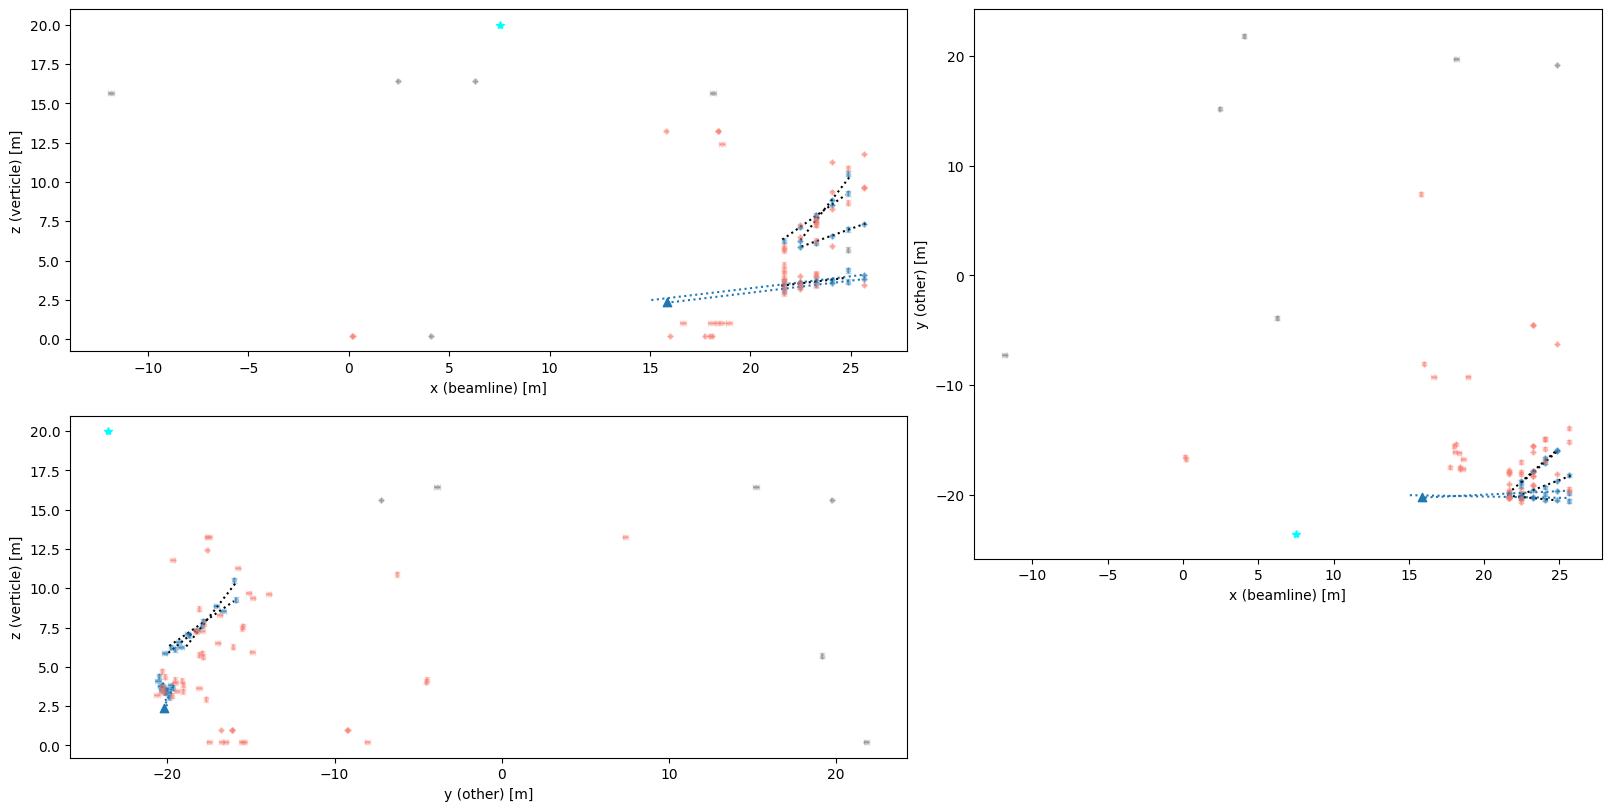

In [328]:
res = res_bkg
mask =  res.get_cut("N_hits vs N_veto") & \
        res.get_cut("N_hits vs N_veto 2") & \
        res.get_cut("N track downward") & \
        res.get_cut("N digi before") #& \
        # res.get_cut("Angle to CMS") #| res.get_cut("True")
print(sum(mask))
plotinds = np.flatnonzero(mask)

i+=1
# i=0
j=plotinds[i]
print(i, j)

data = fbkg.get_entry(j)
event = datatypes.Event(data, metadata_digi)  
event.plot()

150
51 657


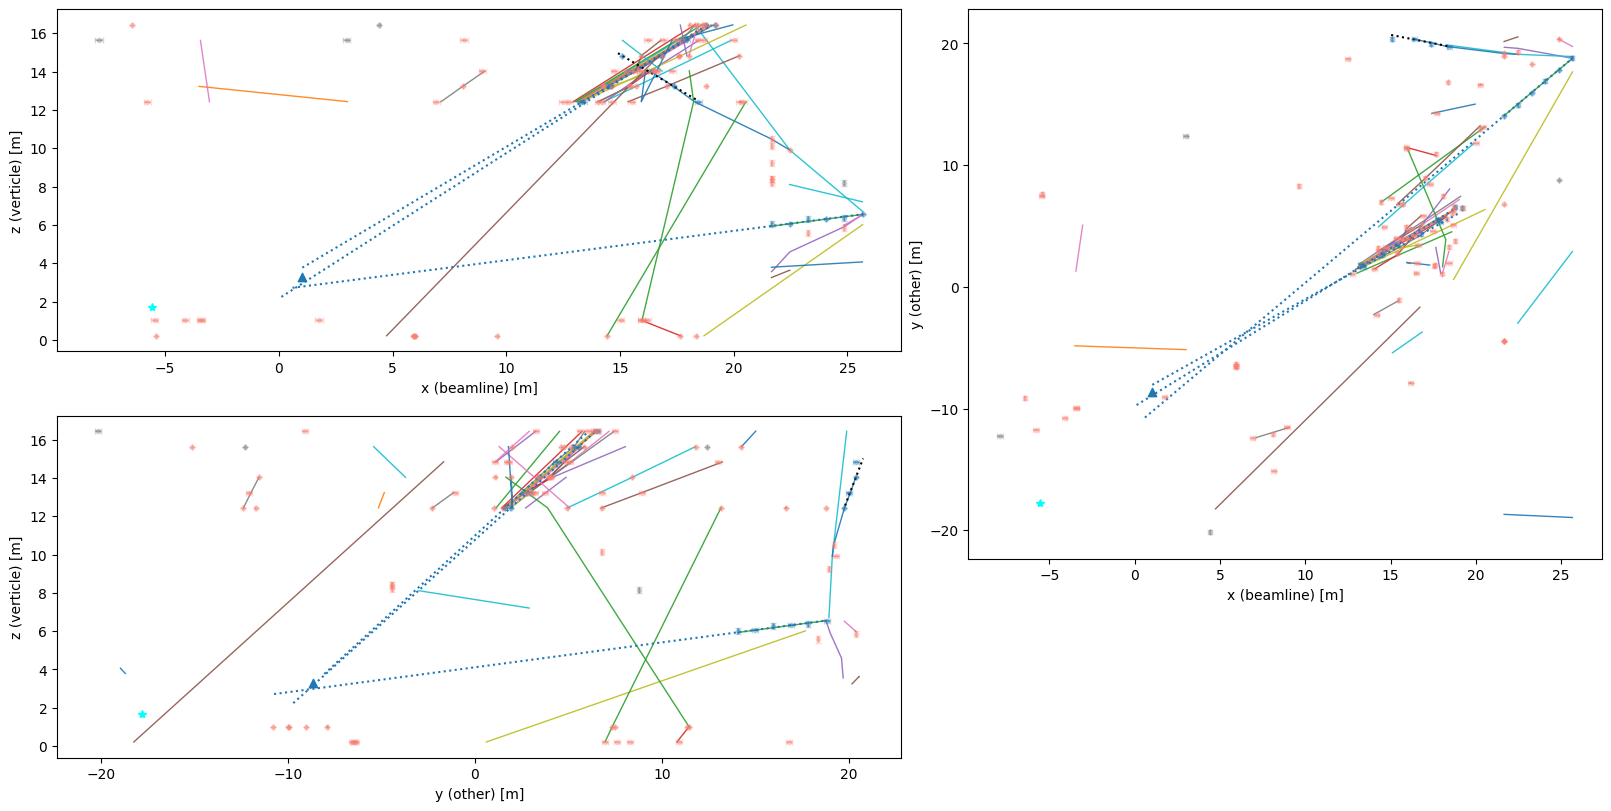

In [438]:
res = res_sig2
mask = res.get_cut("N track downward") & res.get_cut("N_hits vs N_veto") & res.get_cut("N track upward") & res.get_cut("N digi before") #| res.get_cut("True")

mask = mask & (res["vertex_cms_angle_h"] > 0) & (res["vertex_cms_angle_v"]>0)
print(sum(mask))
plotinds = np.flatnonzero(mask)

i+=1
# i=0
j=plotinds[i]
print(i, j)

data = fsig2.get_entry(j)
event = datatypes.Event(data, metadata_digi)  
event.plot()

138
Is top, False
79
75
[10272.731363932291, 8071.797770182292, 5349.173068576389, 5029.164090474446] -126.3390522324134 [20853.691080729168, 22094.638346354168, 23622.854817708332, 22997.919813368055]


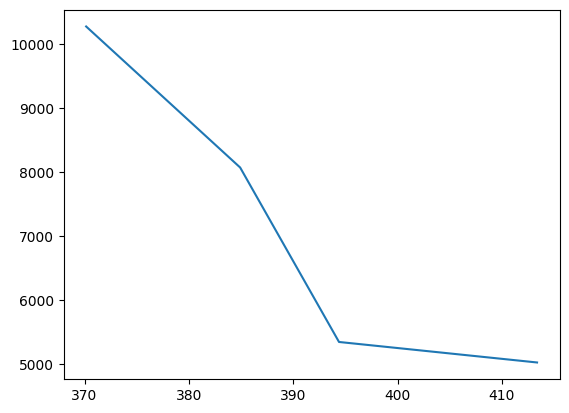

In [516]:
# i=0
i+=1
print(i)
j=plotinds[i]

data = fbkg.get_entry(j)
# data = fsig.get_entry(i)


## Check if the vertex is mostly with top or side tracks
event = datatypes.Event(data, metadata_digi)  
ntracks=[]
for j in range(len(event.vertices)):
    v = event.vertices[j]
    ntracks.append(v.ntracks)
i_vertex = np.argmax(ntracks)
v =  event.vertices[i_vertex]
tracks_are_top = [event.tracks[i].iv_index == 2 for i in v.track_ids]
vertex_is_top  = (sum(tracks_are_top)/len(tracks_are_top))>=0.5
print("Is top,", vertex_is_top)
    


ndiv = 4
digi_t = np.array(data["Digi_t"])
digi_t_inds = np.argsort(digi_t).astype(int)
digi_t_sorted = digi_t[digi_t_inds]

mask, tmean, t_std = util.removeoutliers(digi_t, skew_itermax=1, std_itermax=1)
print(len(digi_t_inds))
t_std = max(t_std*2, 300)
t_std = min(t_std, 300)
digi_t_inds = digi_t_inds[(digi_t_sorted<(tmean + t_std)) & 
                          (digi_t_sorted>(tmean - t_std))]
print(len(digi_t_inds))

xs,ys,zs,ts = [],[],[],[]
for igroup in range(ndiv):
    inds = digi_t_inds[len(digi_t_inds)//ndiv*igroup: len(digi_t_inds)//ndiv*(igroup+1)]
    xs.append(np.mean(np.array(data["Digi_x"])[inds]))
    ys.append(np.mean(np.array(data["Digi_y"])[inds]))
    zs.append(np.mean(np.array(data["Digi_z"])[inds]))
    ts.append(np.mean(np.array(data["Digi_t"])[inds]))
    # print(np.array(data["Digi_z"])[inds])

            # 2. Check if the overall trend is going downwards
dzdt, intercept, r, p, std_err = scipy.stats.linregress(ts, zs)
print(zs, dzdt, xs)
plt.plot(ts, zs)

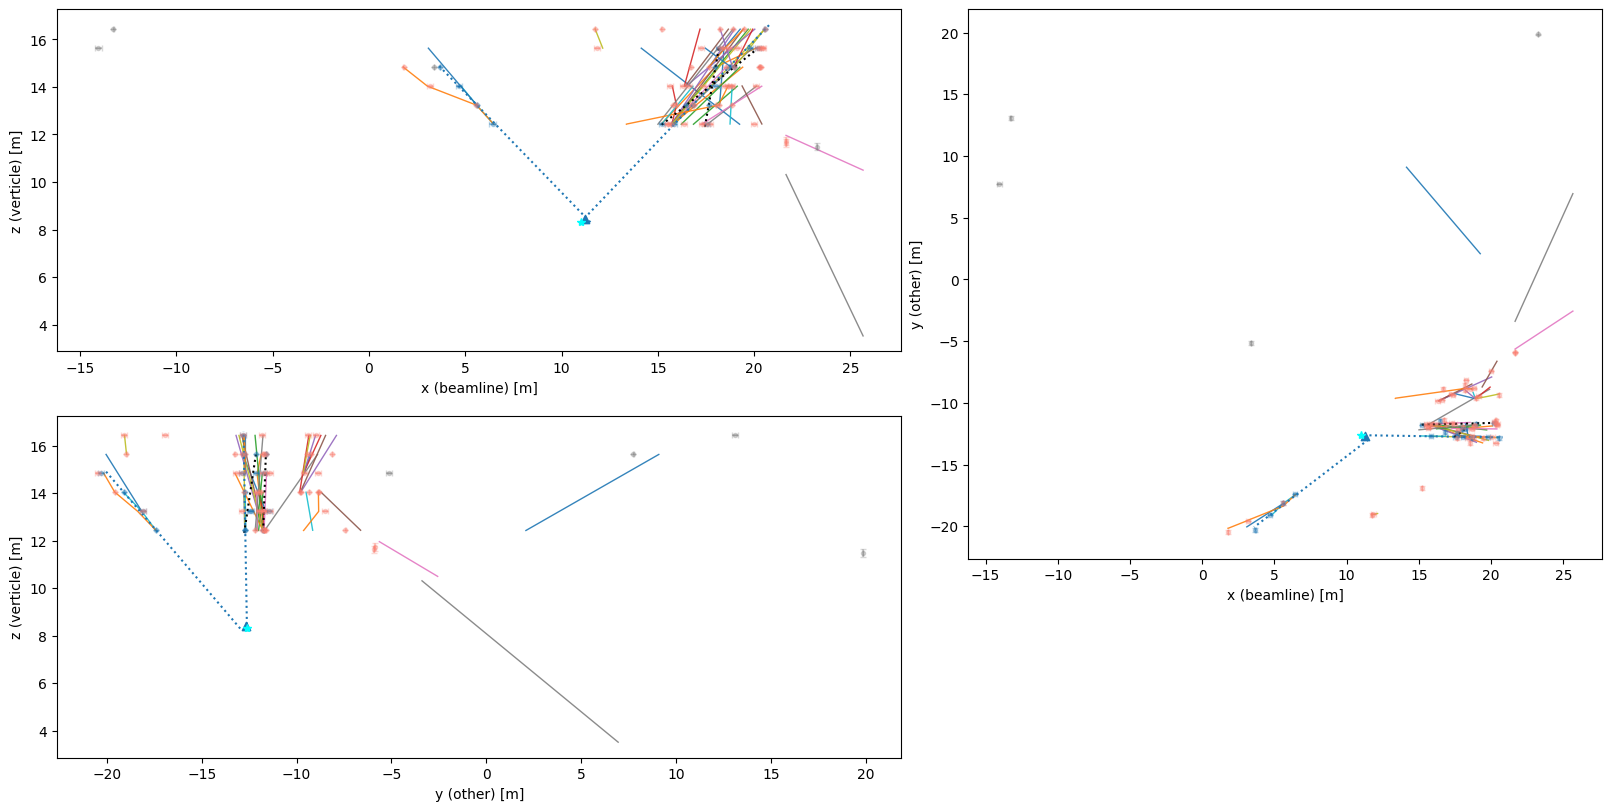

In [835]:
i+=1
data = fsig.get_entry(i)
# j=plotinds[i]
# data = fbkg.get_entry(j)
event = datatypes.Event(data, metadata_digi, parse_truth=True)  
event.plot()

In [200]:
digi_t_inds, digi_t, np.mean(digi_t_sorted)

(array([ 1, 31]),
 array([-477.237, -345.373, -546.867, -542.722, -492.702, -485.434, -479.765, -474.759, -467.991, -554.036, -554.312, -554.329, -548.031,  209.807, -506.809,  134.302, -551.797, -550.14 , -553.439, -431.875, -429.467, -427.109, -423.156, -421.446, -416.567, -431.238, -550.834, -548.575, -505.665, -540.891, -450.414, -226.824, 1280.711,  308.592,  340.738,  552.923, 1907.71 ,  311.334,  682.809,  459.936]),
 -207.52352981567384)

In [79]:
data["Track_kt"], data["Track_t0"], data["Vertex_t0"]

([0.0061717857606709,
  -0.004022068344056606,
  0.005835135001689196,
  0.0048088207840919495],
 [-263.46185302734375,
  -366.9369812011719,
  -294.78448486328125,
  -306.8486633300781],
 [-329.5685119628906])

In [1302]:
data.keys()

dict_keys(['SimEntry', 'Track_x0', 'Track_y0', 'Track_z0', 'Track_t0', 'Track_kx', 'Track_ky', 'Track_kz', 'Track_kt', 'Track_cov', 'Track_chi2', 'Track_id', 'Track_iv_ind', 'Track_iv_err', 'Track_digiInds', 'Vertex_x0', 'Vertex_y0', 'Vertex_z0', 'Vertex_t0', 'Vertex_cov', 'Vertex_chi2', 'Vertex_id', 'Vertex_trackInds', 'Vertex_tracklet_n0', 'Vertex_tracklet_n2', 'Vertex_tracklet_n3', 'Vertex_tracklet_n4p', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_t', 'Digi_edep', 'Digi_trackID', 'Digi_pdgID', 'Digi_detectorID', 'Digi_type', 'Digi_hitInds', 'Digi_direction', 'Run_number', 'Evt_number', 'Seed_0', 'Seed_1', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_t', 'Hit_edep', 'Hit_px', 'Hit_py', 'Hit_pz', 'Hit_trackID', 'Hit_trackIDparent', 'Hit_pdgID', 'Hit_pdgIDparent', 'Hit_isprimary', 'Hit_processID', 'Hit_detectorID', 'Gen_x', 'Gen_y', 'Gen_z', 'Gen_t', 'Gen_px', 'Gen_py', 'Gen_pz', 'Gen_pdgID', 'Gen_index', 'Step_x', 'Step_y', 'Step_z', 'Step_t', 'Step_edep', 'Step_px', 'Step_py', 'Step_pz', 'Step_trackID', 

In [15]:
data["Vertex_selected_ind"]

KeyError: 'Vertex_selected_ind'

In [18]:
fsig2.tree

for branch in fsig2.tree.GetListOfBranches():
    # Get the leaf for the branch
    leaf = branch.GetLeaf(branch.GetName())
    # Get the data type of the leaf
    data_type = leaf.GetTypeName()
    
    print(leaf)

Name: SimEntry Title: SimEntry
Name: Track_x0 Title: Track_x0
Name: Track_y0 Title: Track_y0
Name: Track_z0 Title: Track_z0
Name: Track_t0 Title: Track_t0
Name: Track_kx Title: Track_kx
Name: Track_ky Title: Track_ky
Name: Track_kz Title: Track_kz
Name: Track_kt Title: Track_kt
Name: Track_cov Title: Track_cov
Name: Track_chi2 Title: Track_chi2
Name: Track_id Title: Track_id
Name: Track_iv_ind Title: Track_iv_ind
Name: Track_iv_err Title: Track_iv_err
Name: Track_digiInds Title: Track_digiInds
Name: Vertex_x0 Title: Vertex_x0
Name: Vertex_y0 Title: Vertex_y0
Name: Vertex_z0 Title: Vertex_z0
Name: Vertex_t0 Title: Vertex_t0
Name: Vertex_cov Title: Vertex_cov
Name: Vertex_chi2 Title: Vertex_chi2
Name: Vertex_id Title: Vertex_id
Name: Vertex_trackInds Title: Vertex_trackInds
Name: Vertex_tracklet_n0 Title: Vertex_tracklet_n0
Name: Vertex_tracklet_n2 Title: Vertex_tracklet_n2
Name: Vertex_tracklet_n3 Title: Vertex_tracklet_n3
Name: Vertex_tracklet_n4p Title: Vertex_tracklet_n4p
Name: Digi_

In [20]:
fsig2.tree.GetEntry(0)
getattr(fsig2.tree, "Vertex_selected_ind")

0

In [28]:
fsig2 = root.tfile_reader(fname_sig2)
fsig2.ls()
fsig2.get_tree("data;1")
print("Entries", fsig2.entries)

None
Entries 9120
TFile**		/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_45_digi_recon_skim.root	
 TFile*		/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_45_digi_recon_skim.root	
  KEY: TTree	metadata;1	Metadata for reconstruction
  KEY: TTree	metadata_digi;1	Metadata for digitization
  KEY: TTree	metadata_recon;1	Simulation metadata
  KEY: TTree	data;1	Reconstruction Tree Skimmed


In [22]:
i=501
data = fsig2.get_entry(i)
# j=plotinds[i]
# data = fbkg.get_entry(j)
event = datatypes.Event(data, metadata_digi, parse_truth=True)  
event.plot()

NameError: name 'metadata_digi' is not defined

In [ ]:
# ----------------------------------------------------------------------
class TrackletFinder:
    def __init__(self, parameters=None, method="recursive", debug=False):
        self.method = method # {"recursive", "greedy"}
        self.debug = debug
        self.parameters={
            "cut_track_SeedSpeed": 1,               # in the unit of c. Limit the maximum speed formed by the seed.
            "cut_track_HitAddChi2": 15,             # Only used when method is "greedy"
            "cut_track_HitDropChi2": 15,            # Set to -1 to turn off
            "cut_track_HitProjectionSigma": 10,     # Number of sigmas
            "cut_track_TrackChi2Reduced": 3,        # Only use this for track with 3 hits
            "cut_track_TrackChi2Prob": 0.9,         # Chi-square probablity (calculated from chi2_cdf(x, DOF))
            "cut_track_TrackNHitsMin": 3,           # Minimum number of hits per track
            "cut_track_TrackSpeed": [25,35],        # [cm/ns], [speed_low, speed_high]. 30 is the speed of light
            "fit_track_MultipleScattering": False,
            "cut_track_MultipleScatteringFind": False,
            "fit_track_Method": "backward", # choose one of {"backward", "forward", "forward-seed", "least-square", "least-square-ana"}
            "fit_track_LeastSquareIters":2, # No need to change
            "multiple_scattering_p": 500, # [MeV/c] momentum of multiple scattering, 
            "multiple_scattering_length": 0.06823501107481977 # [1] material thickness in the unit of scattering length
        }

    def seed(self):
        return

    def find_once(self):

        return

    def find_all(self):
        return

    def remove_used(self):
        return